# An√°lise da Rede dos Usu√°rios que Tweetaram sobre o BBB22

# Introdu√ß√£o

 Para a realiza√ß√£o do presente estudo, foram analisados alguns dados provenientes da API do Twitter. Tal API pode ser acessada atrav√©s da p√°gina do Twitter Developer. Ap√≥s passar por alguns processos de seguran√ßa submetidos pelo pr√≥prio Twitter o acesso √† API √© liberado para que voc√™ possa ter acesso alguns a dados (Com algumas limita√ß√µes de quantidade) disponibilizados pela rede social.<br><br>No que diz respeito a esse trabalho, os dados coletados foram utilizados para a cria√ß√£o de uma rede. Para isso, utilizamos como tema para a realiza√ß√£o da pesquisa a hashtag BBB22 (Referente ao reality show Big Brother Brasil 2022).<br><br>Com base nos resultados dessa pesquisa, um grafo (rede) foi criado para analisar os usu√°rios que tweetam sobre a hashtag BBB22 bem como as men√ß√µes feitas nessas postagens.<br><br>No contexto da rede criada, cada usu√°rio corresponde a um n√≥ na rede e cada men√ß√£o que um usu√°rio faz a outro corresponde a uma aresta (link) entre o n√≥ referente ao usu√°rio que mencionou e o n√≥ correspondente ao usu√°rio mencionado. A rede modelada se caracteriza como dirigida.

 Desse modo foi gerado o grafo utilizando uma parte do dataset (Com apenas 500 usu√°rios) fornecido com o objetivo de realizar an√°lises sobre a disposi√ß√£o da rede atrav√©s de grandezas conhecidas, criando gr√°ficos e exibindo os n√≥s com valores mais importantes.

 No que diz respeito ao ranqueamento dos n√≥s (Node Ranking) as m√©tricas estudadas foram: Degree centrality, Betweenness Centrality e EigenVector centrality.

 Al√©m disso, foram feitas uma an√°lise bivariada (PDF e CDF) e uma an√°lise da decomposi√ß√£o da rede.

### Instala√ß√£o e importa√ß√£o de bibliotecas

In [1]:
# !pip install Twython

In [2]:
#imports
from twython import Twython, TwythonError
import itertools
from time import sleep
import networkx as nx
from tqdm import *
import pickle
from datetime import datetime
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Captura de dados com API do Twetter

Para conseguir acesso a API foi necess√°rio criar uma conta como desenvolvedor no Twetter, para que assim fosse criado um projeto, no nosso caso como estudantes, para conseguir as credenciais necess√°rias para realizar as buscas por dados na API.

O c√≥digo abaixo pega as credenciais do arquivo `keys.txt`.

In [3]:
# open the keys file
my_file = open("keys.txt", "r")

# read the raw data
content = my_file.read()

# split all lines by  newline character
API_KEY, API_SECRET_KEY = content.split("\n")

# close the file
my_file.close()

A seguir s√£o utilizadas as credenciais do arquivo gerar um link que ser√° utilizado para autentica√ß√£o.

In [4]:
twitter = Twython(API_KEY, API_SECRET_KEY)

authentication_tokens = twitter.get_authentication_tokens()
print(authentication_tokens['auth_url'])

https://api.twitter.com/oauth/authenticate?oauth_token=23ryoAAAAAABZMV4AAABfwn2IpI


Atrav√©s do link gerado √© poss√≠vel se autenticar utilizando a conta de desenvolvedor e o projeto criado, para obter o c√≥digo de acesso que ser√° colocado no input do c√≥digo abaixo:

In [5]:
# Replace the verifier with the pin number obtained with your web browser in the previous step
VERIFIER = input("codigo da API:")

twitter = Twython(API_KEY, API_SECRET_KEY,
                  authentication_tokens['oauth_token'],
                  authentication_tokens['oauth_token_secret'])

authorized_tokens = twitter.get_authorized_tokens(VERIFIER)

Ap√≥s a autentica√ß√£o √© poss√≠vel verificar os dados da conta de desenvolvedor respons√°vel pelo uso da API.

In [6]:
twitter = Twython(API_KEY, API_SECRET_KEY,
                  authorized_tokens['oauth_token'],
                  authorized_tokens['oauth_token_secret'])

twitter.verify_credentials()

{'id': 1492858863963492354,
 'id_str': '1492858863963492354',
 'name': 'Hugo Santos UF',
 'screen_name': 'hf_santosUF',
 'location': '',
 'description': '',
 'url': None,
 'entities': {'description': {'urls': []}},
 'protected': False,
 'followers_count': 0,
 'friends_count': 6,
 'listed_count': 0,
 'created_at': 'Sun Feb 13 13:51:19 +0000 2022',
 'favourites_count': 0,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': False,
 'verified': False,
 'statuses_count': 0,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': 'F5F8FA',
 'profile_background_image_url': None,
 'profile_background_image_url_https': None,
 'profile_background_tile': False,
 'profile_image_url': 'http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png',
 'profile_image_url_https': 'https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png',
 'profile_link_color': '1DA1F2',
 'profile_s

O uso da API possui limita√ß√µes de busca, com uma certa quantidade de dados que pode ser obtida, essa limita√ß√£o √© reiniciada ap√≥s 15 minutos, o que faz com que possamos novamente realizar a captura dos dados.

O c√≥digo abaixo mostra, por exemplo, qual o limite de tweets que podem ser obtidos e quantos restam no momento. No caso  o limite √© de 18000 a cada 15 minutos.

In [7]:
twitter.get_application_rate_limit_status()['resources']["search"]

{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1645140539}}

Para realizar a busca dos dados de um determinado dia extrapolando a capacidade limitada por tempo da API, foi utilizada a fun√ß√£o `sleep()` que consegue fazer o c√≥digo "dormir" por um certo tempo, que seria aguardar uma quantidade de segundos sem seguir adiante com a execu√ß√£o do c√≥digo.

Como estamos limitados a uma quantidade de dados a cada 15 minutos, o c√≥digo de realiza√ß√£o da coleta dos dados foi feito de forma que o m√°ximo de dados √© extra√≠do e quando a capacidade chega ao limite √© chamada a fun√ß√£o `sleep()`, que inicia os 15 minutos de timeout, para logo depois coletar novamente os dados, esgotando novamente o limite quantas vezes forem necess√°rias.

In [14]:
#  Verificando se o limite est√° completamente disponibilizado

recurso_restante_cheio = False
while(recurso_restante_cheio == False):
  print(twitter.get_application_rate_limit_status()['resources']["search"])

  if(twitter.get_application_rate_limit_status()['resources']["search"]['/search/tweets']['remaining']==180):
    print("Recursos restaurados, iniciando busca!")
    recurso_restante_cheio = True
  
  else:
    print("Ainda n√£o foi restaurada a capacidade de busca!")
    sleep(910)

# quantidade de buscas ir√£o ser realizadas, cada uma ter√° um intervalo de 15 minutos de espera, fora o tempo de execu√ß√£o da busca na API
quantidade_buscas = 4

search_tweets = []
for busca in range(1,quantidade_buscas+1):
  # a cada 15 min podemos pegar 18 mil tweets
  NUM_TWEETS_TO_FETCH = 18000

  print(twitter.get_application_rate_limit_status()['resources']["search"])
  # realizando coleta e salvando na lista search_tweets
  cursor = twitter.cursor(twitter.search, q='#BBB22', count=100, result_type='mixed')
  search_tweets_atual = list(itertools.islice(cursor, NUM_TWEETS_TO_FETCH))
  search_tweets += search_tweets_atual
  
  # imprime o limite esgotado e qual a busca que foi finalizada
  print(twitter.get_application_rate_limit_status()['resources']["search"])
  print("busca:",busca,"finalizada. aguardando tempo para poder realizar novas requisi√ß√µes.")
  
  # caso n√£o esteja na ultima busca √© chamada a fun√ß√£o sleep para aguardar 15 minutos e 10 segundos (10 segundos apenas para precau√ß√£o)
  if(busca != quantidade_buscas):
    sleep(910)

{'/search/tweets': {'limit': 180, 'remaining': 174, 'reset': 1645140541}}
Ainda n√£o foi restaurada a capacidade de busca!
{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1645141686}}
Recursos restaurados, iniciando busca!
{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1645141687}}
{'/search/tweets': {'limit': 180, 'remaining': 0, 'reset': 1645141687}}
busca: 1 finalizada. aguardando tempo para poder realizar novas requisi√ß√µes.
{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1645142764}}
{'/search/tweets': {'limit': 180, 'remaining': 0, 'reset': 1645142764}}
busca: 2 finalizada. aguardando tempo para poder realizar novas requisi√ß√µes.
{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1645143819}}
{'/search/tweets': {'limit': 180, 'remaining': 0, 'reset': 1645143819}}
busca: 3 finalizada. aguardando tempo para poder realizar novas requisi√ß√µes.
{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1645144871}}
{'/search/tweet

Abaixo s√£o separados somente os tweets que tem men√ß√µes a outros usu√°rios, que s√£o os que nos interessam.

In [ ]:
lista_com_mencoes = [tweet  for tweet in search_tweets if  (len(tweet['entities']['user_mentions'])>0)]

Abaixo podemos observar a quantidade total de tweets coletados no dia e quantos possuem men√ß√µes.

In [ ]:
print("Total:",len(search_tweets),"\nCom men√ß√µes:",len(lista_com_mencoes))

Total: 72000 
Com men√ß√µes: 27632


Abaixo utilizamos a biblioteca datetime para capturar a data do dia de hoje, utilizada para compor o nome do arquivo pickle que armazenar√° a lista de tweets obtidos no dia de hoje.

A biblioteca pickle √© utilizada para armazenar em arquivos mais facilmente uma lista ou qualquer estrutura de dados do python.

In [11]:
data = datetime.now().date().strftime('%d-%m-%Y')
print(data)
pickle.dump(lista_com_mencoes, open(f"./dados/lista_com_mencoes{data}.p", "wb"))
# print(f"./dados/lista_com_mencoes{data}.p")

17-02-2022


Ap√≥s obter os dados a cada dia e realizar a grava√ß√£o dos mesmos em arquivos √© necess√°rio realizar a uni√£o de todos para comporem o grafo posteriormente.
O c√≥digo abaixo realiza essa uni√£o de todas as listas dos dias anteriores em uma s√≥: `lista_geral_tweets`.

In [13]:
lista_geral_tweets = []
# o in√≠cio dos dados foi no dia 13, por isso os arquivos come√ßam a ser capturados do dia 13 at√© o dia de hoje.
for dia in range(13,datetime.now().day+1):
    print(f"./dados/lista_com_mencoes{dia}-{data[3:]}.p")
    lista_geral_tweets += pickle.load( open(  f"./dados/lista_com_mencoes{dia}-{data[3:]}.p", "rb") )

./dados/lista_com_mencoes13-02-2022.p
./dados/lista_com_mencoes14-02-2022.p
./dados/lista_com_mencoes15-02-2022.p
./dados/lista_com_mencoes16-02-2022.p
./dados/lista_com_mencoes17-02-2022.p


# EDA - Exploraty Data Analysis

#### Para a realiza√ß√£o de uma an√°lise explorat√≥ria dos dados iremos buscar entender a organiza√ß√£o dos dados que vem da API e como poderemos aproveit√°-los para cria√ß√£o da nossa rede.

Abaixo est√° o primeiro tweet capturado para que seja poss√≠vel analisar quais os dados que podemos trabalhar e qual o formato em que ele se encontra.

In [ ]:
lista_geral_tweets[0]

{'created_at': 'Sun Feb 13 22:27:46 +0000 2022',
 'id': 1492988899081265155,
 'id_str': '1492988899081265155',
 'text': 'RT @vaidesmaiar: B√°rbara perguntando do Arthur. Esl√¥ disse que n√£o vota no Arthur. Barbara quer saber o que conversaram. Esl√¥ disse que foi‚Ä¶',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'vaidesmaiar',
    'name': 'Vai Desmaiar #BBB22',
    'id': 511577335,
    'id_str': '511577335',
    'indices': [3, 15]}],
  'urls': []},
 'metadata': {'iso_language_code': 'pt', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1371886809400143872,
  'id_str': '1371886809400143872',
  'name': 'isabella',
  'screen_name': 'isabellafmcc',
  'location': 'S√£o Lu√≠s, Bra

Podemos observar que cada tweet possui dados sobre o usu√°rio que o realizou e tamb√©m algumas informa√ß√µes sobre o usu√°rio que foi mencionado nesse tweet.

Infelizmente n√£o possuimos muitos dados sobre os usu√°rios mencionados como temos sobre o dono do tweet, o que nos limita em certo ponto, al√©m de que os dados sobre o dono do tweet n√£o aparentam ter grande relev√¢ncia para levarmos em considera√ß√£o al√©m da localiza√ß√£o `location`, que seria interessante de trabalhar-mos se tivessemos tamb√©m essa informa√ß√£o dos mencionados.

 Nesse caso iremos trabalhar apenas com os nomes dos usu√°rios e realizar uma avalia√ß√£o sobre a relev√¢ncia de cada conta a partir do n√∫mero de vezes em que ela √© mencionada por outros usu√°rios em seus tweets.

 Para podermos entender-mos o volume de dados com que estamos trabalhando iremos realizar algumas observa√ß√µes a seguir.

In [ ]:
# Quantidade de tweets capturados unindo todos os dias de captura
print("Quantidade geral de tweets:",len(lista_geral_tweets))

# Soma men√ß√µes dos tweets
quantidade_mentions = 0
lista_usuarios_donos = []
lista_usuarios_mencionados = []
for tweet in lista_geral_tweets:
    lista_usuarios_donos.append(tweet['user']['screen_name'])
    quantidade_mentions += len(tweet['entities']['user_mentions'])
    for mention in tweet['entities']['user_mentions']:
        lista_usuarios_mencionados.append(mention['screen_name'])
print("Quantidade geral de men√ß√µes de todos os tweets:",quantidade_mentions)



Quantidade geral de tweets: 208386
Quantidade geral de men√ß√µes de todos os tweets: 212644


Observando os dados de quantidade de tweets e de men√ß√µes √© poss√≠vel entender que pouqu√≠ssimos tweets fazem men√ß√£o a mais de um usu√°rio, a grande maioria das men√ß√µes s√£o devidos ao tweet ser um retweet de outro usu√°rio, logo cont√©m apenas uma men√ß√£o.

#### 10 usu√°rios com maior n√∫mero de tweets:


10 Usu√°rios com maior n√∫mero de tweets:
Usu√°rio: suelivitoria  -  352
Usu√°rio: fwntdz  -  328
Usu√°rio: dorismac64  -  272
Usu√°rio: gobrotherr  -  220
Usu√°rio: dri_nai  -  215
Usu√°rio: KHHWHAT  -  192
Usu√°rio: jaqueli99515863  -  188
Usu√°rio: tia_meigh2  -  188
Usu√°rio: guricomenta  -  172
Usu√°rio: juuh6520  -  169


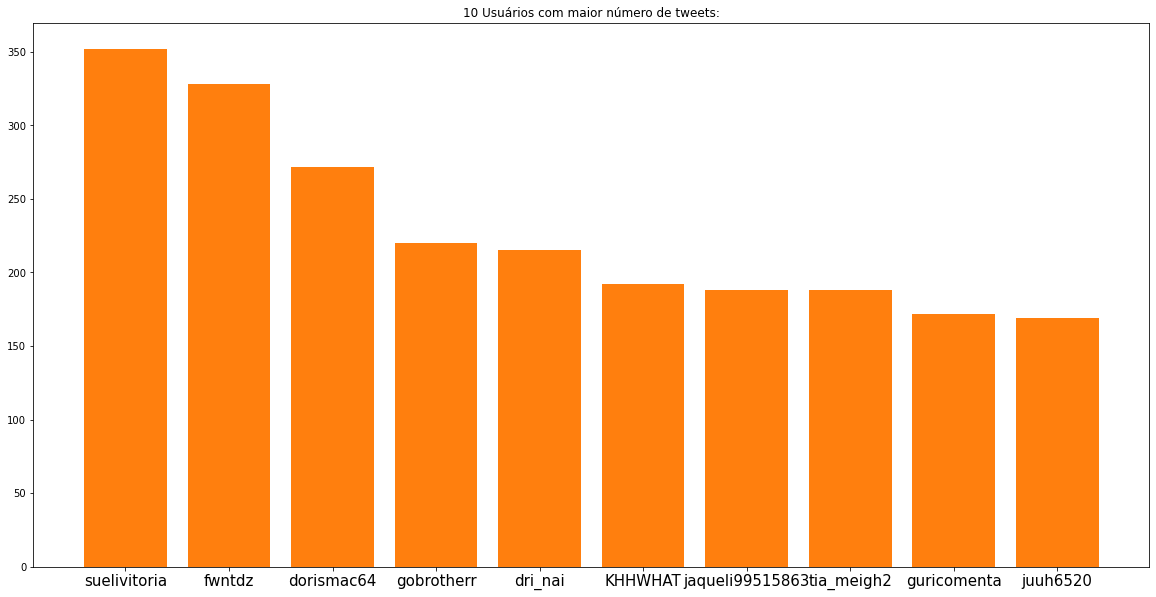

In [ ]:
df_users = pd.DataFrame()
df_users["users"] = lista_usuarios_donos

# Usu√°rios com mais tweets 
print("\n10 Usu√°rios com maior n√∫mero de tweets:")
contador = 0
usuarios = []
valores = []
for user,tweets in list(df_users.users.value_counts().items()):
    usuarios.append(user)
    valores.append(tweets)
    print("Usu√°rio:",user," - ",tweets)
    contador +=1
    if(contador ==10):
        break



plt.figure(figsize =(20,10))
plt.bar(usuarios,valores)
plt.xticks(usuarios,fontsize=15)
plt.title("10 Usu√°rios com maior n√∫mero de tweets:")
plt.bar(usuarios, valores)

plt.show()

#### 10 usu√°rios mais mencionados nos tweets:


10 Usu√°rios mais mencionados nos tweets:
Usu√°rio: vaidesmaiar  -  17897
Usu√°rio: chicobarney  -  13488
Usu√°rio: tracklist  -  11027
Usu√°rio: ZAMENZA  -  7294
Usu√°rio: NazareAmarga  -  4226
Usu√°rio: bchartsnet  -  3942
Usu√°rio: Dantinhas  -  3737
Usu√°rio: choquei  -  3707
Usu√°rio: Itspedrito  -  3465
Usu√°rio: CentralReaIity  -  3454


<BarContainer object of 10 artists>

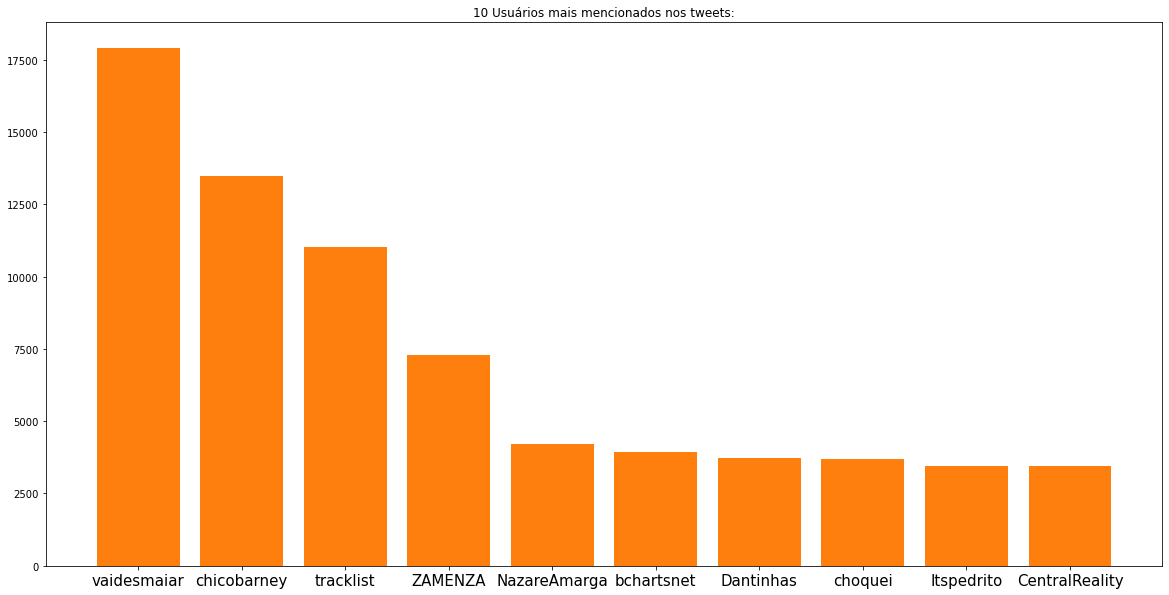

In [ ]:
df_users = pd.DataFrame()
df_users["users"] = lista_usuarios_mencionados

# Usu√°rios mais mencionados
print("\n10 Usu√°rios mais mencionados nos tweets:")
contador = 0
usuarios = []
valores = []

for user,tweets in list(df_users.users.value_counts().items()):
    usuarios.append(user)
    valores.append(tweets)
    print("Usu√°rio:",user," - ",tweets)
    contador +=1
    if(contador ==10):
        break


plt.figure(figsize =(20,10))
plt.bar(usuarios,valores)
plt.xticks(usuarios,fontsize=15)
plt.title("10 Usu√°rios mais mencionados nos tweets:")
plt.bar(usuarios, valores)

# Criando, corrigindo e analizando o Grafo 

O grafo √© criado utilizando o Networkx, em que √© criado um grafo dirigido e que ter√° como peso a quantidade de men√ß√µes que um usu√°rio fez ao outro em seus tweets.

Por exemplo, se @Jo√£o fez 2 tweets mencionando @Maria ent√£o a rede ir√° possuir a seguinte forma: 

Jo√£o ----> Maria, em que o peso dessa aresta seria 2, devido aos 2 tweets.

Abaixo est√° o c√≥digo respons√°vel pela cria√ß√£o da rede dessa forma.

In [ ]:
# cria o grafo vazio
D = nx.DiGraph()
# utilizado para cria√ß√£o de uma parra de progresso
pbar = tqdm(total=len(lista_geral_tweets)) 

# itera por tweets
for tweet in lista_geral_tweets:
    # dono do tweet
    tweet_sn = tweet['user']['screen_name']
    
    # usu√°rios mencionados
    for user_mention in tweet['entities']['user_mentions']:
        mentioned_sn = user_mention['screen_name']  
        my_edge = (tweet_sn, mentioned_sn)
        # adiciona arestas do dono para os mencionados
        if D.has_edge(*my_edge):
            D.edges[my_edge]['weight'] += 1
        else:
            D.add_edge(*my_edge, weight=1)
    pbar.update(1)
    

 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 175971/180754 [00:02<00:00, 69772.88it/s]

Com o objetivo de possibilitar as an√°lises do grafo em tempo h√°bil foi realizada a filtragem do n√∫mero de n√≥s, mantendo somente os 500 que possuem maior observando suas arestas.

Para isso foi necess√°rio primeiro observar quem s√£o os graficos com maior grau:

In [ ]:
# Pegando usu√°rios com maior Grau e salvando em lista
lista_pesos = [[peso[1],peso[0]] for peso in list(D.degree(weight='weight'))]
lista_pesos.sort(reverse=True)

# Pegando lista somente com nomes de usu√°rios na ordem de maior grau para o menor
lista_usuarios = [usuario for grau,usuario in lista_pesos]

Abaixo est√° o c√≥digo que exibe os 10 n√≥s com maior peso, e qual o seu peso.

In [ ]:
lista_pesos[:10]

[[15192, 'vaidesmaiar'],
 [12877, 'chicobarney'],
 [8035, 'tracklist'],
 [6790, 'ZAMENZA'],
 [3736, 'NazareAmarga'],
 [3590, 'Dantinhas'],
 [3445, 'Itspedrito'],
 [3272, 'bchartsnet'],
 [3192, 'choquei'],
 [2955, 'bbb']]

Abaixo o c√≥digo em que √© poss√≠vel escolher quantos n√≥s ser√£o mantidos.

In [ ]:
# Quantidade de n√≥s com maior grau que ser√£o mantidos no grafo
quantidade_nodes = 500

# Cria um grafo somente com os nodes desejados 
subgraph = D.subgraph(lista_usuarios[:quantidade_nodes])

# Armazena grafo em arquivo para usos posteriores
nx.write_graphml(subgraph, str(quantidade_nodes)+'_perfis.graphml')


# Node ranking

Foram analisadas tamb√©m algumas m√©tricas referentes ao Node Ranking, isto √©, o ranqueamento dos n√≥s. Atrav√©s dessas m√©tricas de ranqueamento podemos definir a import√¢ncia de um n√≥ para a rede.

### Degree Centrality

Antes de falarmos da m√©trica degree centrality, √© interessante o conhecimento sobre o degree (grau) de um n√≥.

O grau de um n√≥, nada mais √© do que a quantidade de conex√µes que um n√≥ tem. Por exemplo, se um n√≥ possui 5 conex√µes ent√£o ele possui grau 5.

O c√≥digo a seguir gera um gr√°fico que mostra a rela√ß√£o dos n√≥s da rede analisada com seus graus:

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 180754/180754 [00:20<00:00, 69772.88it/s]

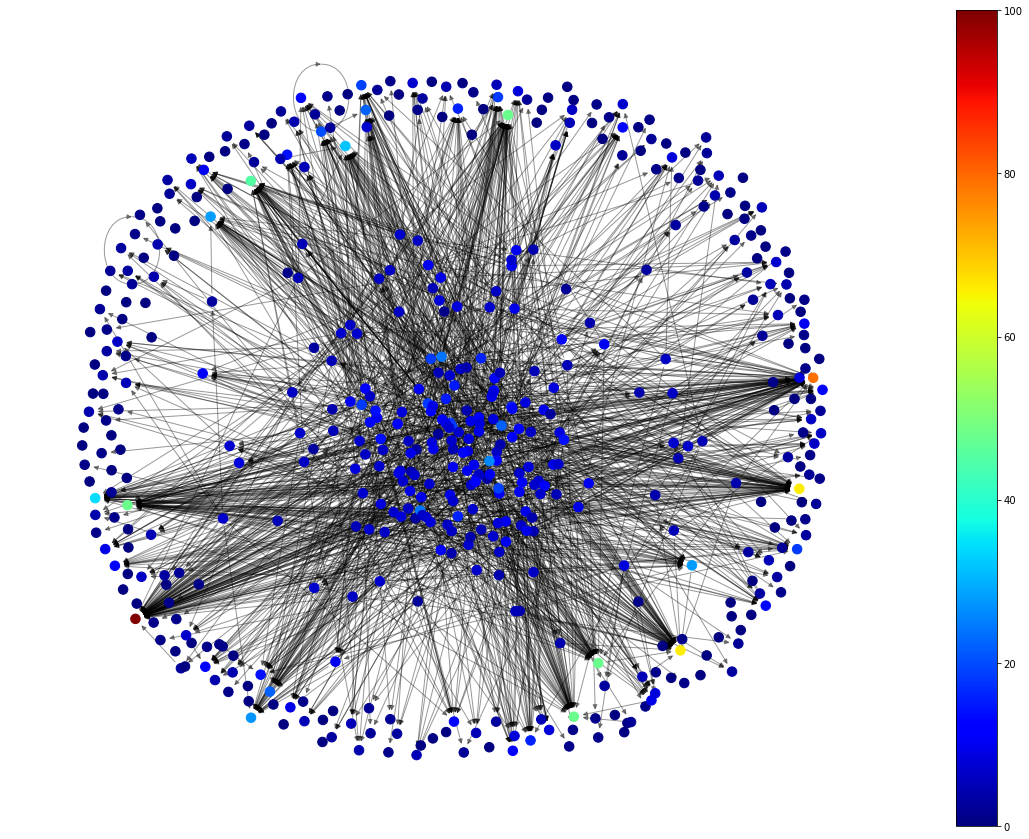

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes based on eccentricity
color = list(dict(nx.degree(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('./figuras/eccentricity.png', transparent=True,dpi=300)
plt.show()



O degree centrality, por sua vez, trata-se do grau de um n√≥ dividido pelo n√∫mero m√°ximo de vizinhos que um n√≥ pode ter na rede, gerando assim um valor entre 0 e 1.
¬†
O processo de dividir o grau do n√≥ pelo n√∫mero m√°ximo poss√≠vel de vizinhos que ele pode ter √© feito para que seja poss√≠vel comparar redes de tamanhos diferentes utilizando a mesma m√©trica. Isso porque um n√≥ de grau 5 em uma rede com  10 n√≥s possui uma import√¢ncia diferente do que se esse mesmo n√≥ estivesse em uma rede com 100 v√©rtices, por exemplo.

Gerando o grafo de degree centrality da nossa rede analisada atrav√©s do c√≥digo abaixo obtivemos:

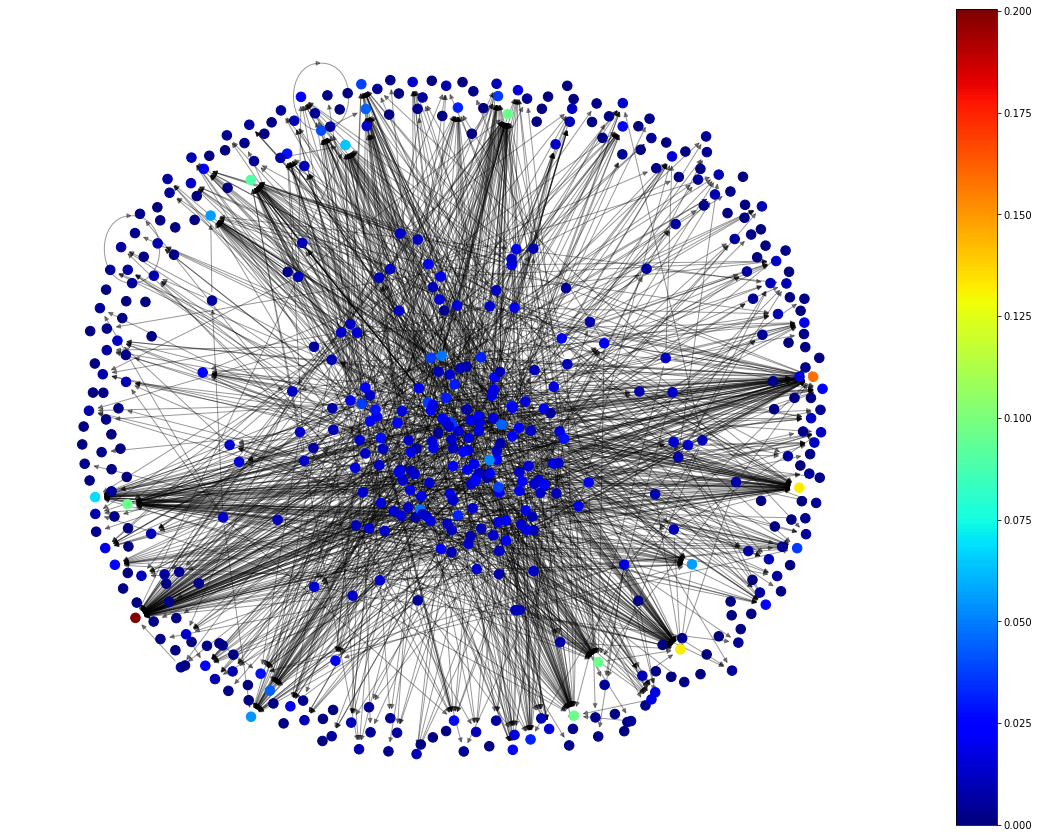

In [ ]:
# the degree centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree_centrality(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('./figuras/degree_centrality.png', transparent=True,dpi=300)
plt.show()

Observando a figura √© poss√≠vel identificar claramente que os n√≥s com valores mais altos de grau possuem realmente mais conex√µes com outros n√≥s, principalmente os que tem as cores mais pr√≥ximas ao vermelho.

Perceba que o gr√°fico √© igual ao gr√°fico de n√≥s comuns, por√©m com os valores gerados estando entre 0 e 1.

Atrav√©s do c√≥digo abaixo foi poss√≠vel obter a lista dos 10 usu√°rios (n√≥s) com maior grau na rede junto de seus respectivos degree centralities¬†, que s√£o:

In [ ]:
# Pega lista n√≥s e seu respectivo degree_centrality ordenado do maior para o menor
lista_grau_centralidade = [[value,key] for key,value in nx.degree_centrality(subgraph).items()]
lista_grau_centralidade.sort(reverse=True)

# imprime usu√°rios e graus
print("Usu√°rio \t     Grau \n")
for grau,usuario in lista_grau_centralidade[:10]:
  print ("{:<20} {:<15}".format( usuario, grau))

Usu√°rio 	     Grau 

vaidesmaiar          0.2004008016032064
ZAMENZA              0.15831663326653306
bbb                  0.13226452905811623
Dantinhas            0.13226452905811623
tracklist            0.09619238476953906
jadre_oficial        0.09619238476953906
choquei              0.09619238476953906
chicobarney          0.09619238476953906
CentralReaIity       0.09018036072144288
paiva                0.06813627254509018


### Resultado
Observando essa m√©trica podemos perceber que os n√≥s com maior grau s√£o aqueles com mais relev√¢ncia dentro da nossa problem√°tica e dentro da rede, pois eles s√£o os que em geral tweets que s√£o constantemente retweetados, pelo maior n√∫mero de usu√°rios e pelos usu√°rios mais relevantes, e s√£o muito mencionados por outros usu√°rios que est√£o interessados no programa BBB.

## Betweenness Centrality

Essa m√©trica define quais s√£o os n√≥s mais importantes em fazer a liga√ß√£o entre os outros n√≥s, o grau de participa√ß√£o daquele n√≥ nos menores caminhos de todos os n√≥s entre si. Em outras palavras, o quanto um determinado grau faz parte do fluxo de caminhos ou informa√ß√µes.

A figura abaixo exibe a rede sob a √≥tica da aplica√ß√£o do Betweenness centrality:

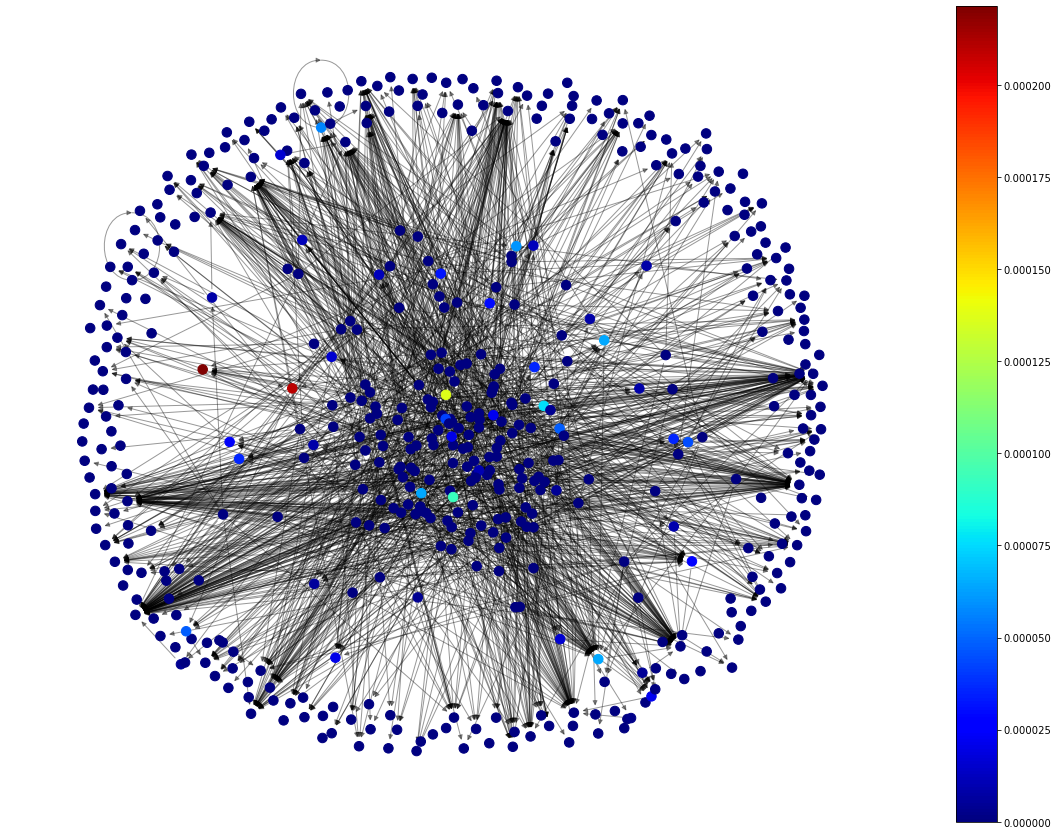

In [ ]:
# the betwenness centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.betweenness_centrality(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('./figuras/betweenness_centrality.png', transparent=True,dpi=600)
plt.show()

Observando a figura tendo em mente o conceito da m√©trica √© poss√≠vel ver claramente que os n√≥s que mais se destacam s√£o aqueles que est√£o fazendo o interm√©dio entre os n√≥s com maior grau e o restante dos n√≥s, fazendo a fun√ß√£o de ponte entre os n√≥s.

Abaixo est√£o exibidos os 10 n√≥s com maior destaque na rede para essa m√©trica:

In [ ]:
# Pega lista n√≥s e seu respectivo betweenness_centrality ordenado do maior para o menor
lista_entre_nodes = [[value,key] for key,value in nx.betweenness_centrality(subgraph).items()]
lista_entre_nodes.sort(reverse=True)

# Imprime usuarios e m√©trica
print("Usu√°rio \t     Grau \n")
for grau,usuario in lista_entre_nodes[:10]:
  print ("{:<20} {:<15}".format( usuario, grau))

Usu√°rio 	     Grau 

plantasarradora      0.00022132618650956532
dcxdxt               0.00020925384906358903
TvViciada            0.00013681982438773128
frothcream           9.255458708581823e-05
Nnise_Rrose          7.645813715784983e-05
jadre_oficial        6.472114241870622e-05
yliieat              6.438579971187355e-05
aktaion16            6.438579971187355e-05
jessialveshq         6.036168722988145e-05
GregoMalandro        5.633757474788935e-05


### Resultado
Depois de analizar a figura juntamente com os 10 usu√°rios mais destacados nessa m√©trica √© poss√≠vel perceber que muito provavelmente esses usu√°rios s√£o como se fossem p√°ginas secund√°rias, que tem seus pr√≥prios seguidores e postam seus pr√≥prios conte√∫dos mas tamb√©m repostam e fazem muitas men√ß√µes aos usu√°rios mais importantes da rede, os que possuem maior grau, vistos anteriormente na degree centrality.

## EigenVector Centrality

A m√©trica Eigenvector centrality (Autovetor) mede a import√¢ncia de um n√≥ de acordo com a import√¢ncia dos seus vizinhos. A grosso modo, a ideia √© a de que se eu sou "amigo" de algu√©m importante eu sou importante tamb√©m.

Abaixo a figura exibindo a rede com a aplica√ß√£o do EigenVector Centrality:

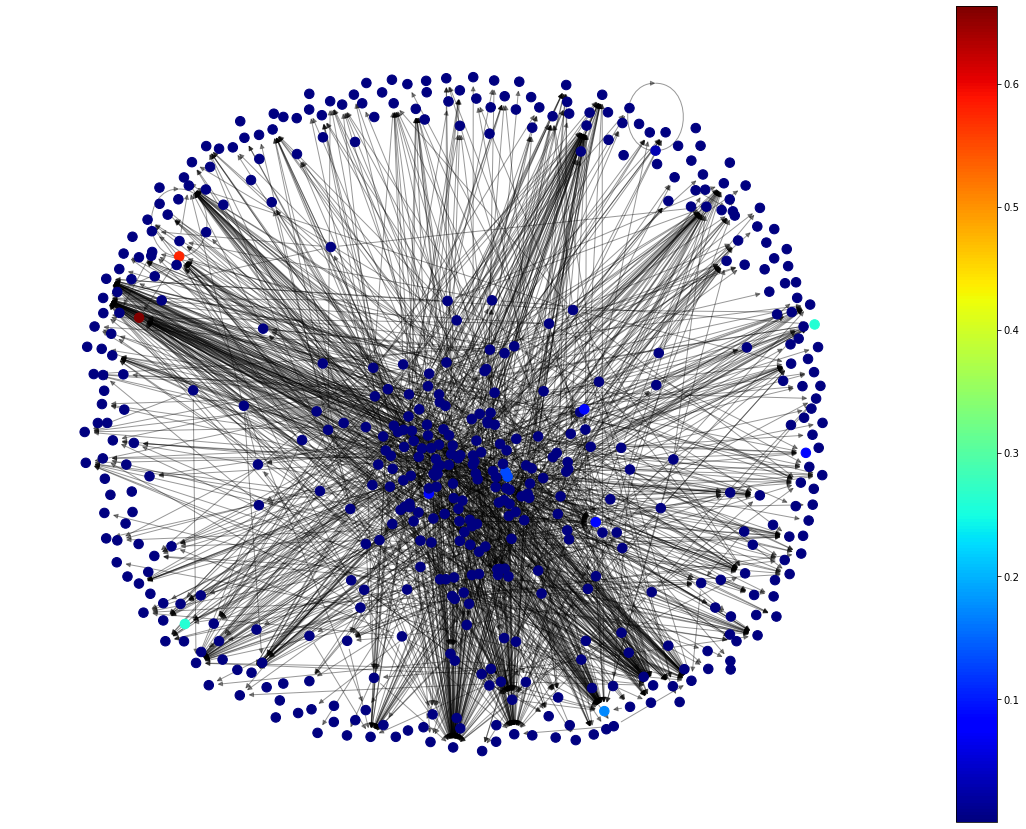

In [ ]:
# the eigenvector centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.eigenvector_centrality(subgraph)).values())

# draw edges
nx.draw_networkx_edges(subgraph,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size = 90)

# draw labels
# nx.draw_networkx_labels(subgraph, pos=pos,
#                         font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('./figuras/eigenvector_centrality.png', transparent=True,dpi=600)
plt.show()

Abaixo est√£o exibidos os 10 n√≥s com maior destaque na rede para essa m√©trica.

In [ ]:
# Pega lista n√≥s e seu respectivo betweenness_centrality ordenado do maior para o menor
lista_autovetor = [[value,key] for key,value in nx.eigenvector_centrality(subgraph).items()]
lista_autovetor.sort(reverse=True)

# Imprime usu√°rios e m√©trica
print("Usu√°rio \t     Grau \n")
for grau,usuario in lista_autovetor[:10]:
  print ("{:<20} {:<15}".format( usuario, grau))

Usu√°rio 	     Grau 

iampauloandre        0.6627067136854489
GregoMalandro        0.5762673027473645
boninho              0.25932522525177626
PedroScooby          0.25932112729525314
bbb                  0.172908545317226
anafalabobeira2      0.12966016273957442
anafalabobeira       0.12966015715798979
jadepicon            0.08644035207912888
voleimomento         0.08644024774643104
EuFraaan             0.0864401260249501


### Resultado
Devido a natureza da m√©trica podemos observar que os usu√°rios mais destacados aqui s√£o os mais mensionados pelos usu√°rios mais relevantes, tanto que alguns dos mais destacados s√£o os usu√°rios de participantes do BBB22, como `PedroScooby`, `jadepicon` e `iampauloandre`. Al√©m de termos tamb√©m perfis de pessoas importantes como o `boninho`, o diretor do BBB.

# An√°lise Bivariada (PDF e CDF)

A Probability Density Function (PDF) √© uma fun√ß√£o que possui a capacidade de informar a probabilidade de uma vari√°vel assumir um determinado valor.

Aplicamos essa fun√ß√£o na rede em rela√ß√£o √† m√©trica degree dos n√≥s para verificarmos a probabilidade de um n√≥ da rede ter um determinado grau.

Abaixo a figura exibindo a rede com a aplica√ß√£o da PDF em rela√ß√£o ao grau dos n√≥s e o histograma dos graus:

Abaixo a figura exibindo a rede com a aplica√ß√£o da PDF em rela√ß√£o ao grau dos n√≥s com a linha KDE:

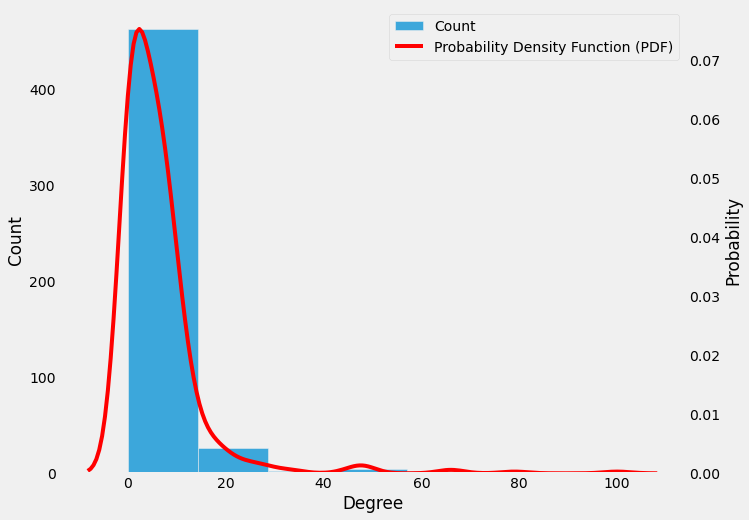

In [ ]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))
degree_sequence = sorted([d for n, d in subgraph.degree()], reverse=True)  

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('./figuras/probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

### Resultado
A fun√ß√£o PDF aplicada ao nosso grafo mostrou que a maioria dos n√≥s possuem grau entre 0 e 20, com alguns poucos acima de 40.

### CDF - Cumulative Density Function

A fun√ß√£o Cumulative Density Function tem a capacidade de definir a probabilidade de um dado valor estar em um determinado intervalo acumulado.

Abaixo a figura exibindo a rede com a aplica√ß√£o da CDF levando em considera√ß√£o o grau dos n√≥s.

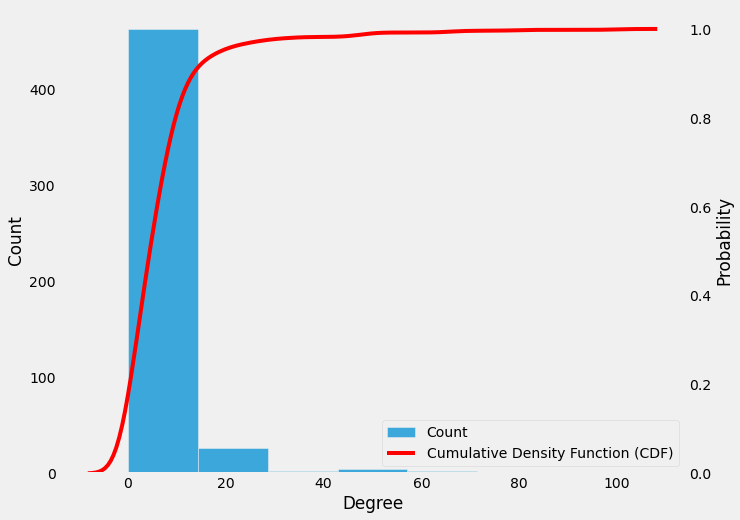

In [ ]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('./figuras/cumulative_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

# Resultado 
Observando essa figura podemos perceber que aproximadamente 90% dos n√≥s est√° entre 0 e 20 no valor de seus graus.

# An√°lise de decomposi√ß√£o da rede

A an√°lise de decomposi√ß√£o da rede consiste em decompor a rede em camadas denominadas cores. Cada camada da rede leva em considera√ß√£o o grau dos n√≥s. Por exemplo, a camada 1-core refere-se ao conjunto de n√≥s das redes cujo grau √© no m√≠nimo 1. O 2-core os n√≥s que possuem grau 2 ou maior, 3-core os que possuem grau 3 ou mais etc. O √∫ltimo core de uma rede √© denominado n√∫cleo dessa rede.

Al√©m do core, outra ideia utilizada na an√°lise de decomposi√ß√£o √© a do shell. O shell faz refer√™ncia √† camada que foi retirada para alcan√ßar um determinado core. Por exemplo, para alcan√ßar a camada 2-core os n√≥s da rede cujo grau √© igual a 1 precisou ser retirada, a essa camada retirada d√°-se o nome de 1-shell. Assim, para alcan√ßar a camada 3-core precisa-se tirar o 2 shell e assim por diante.

Vale lembrar que essas camadas n√£o precisam necessariamente serem incrementadas de um em um,isto √©, pode ser que exista uma rede cujas camadas s√£o: 1-core, 3-core e 4-core. Perceba que nesse exemplo n√£o existe o 2-core, o que √© totalmente poss√≠vel (√â como se nessa rede n√£o existissem n√≥s de grau 2).

O trecho de c√≥digo abaixo nos fornece algumas informa√ß√µes gerais sobre as camadas da rede.

In [ ]:
subgraph_sem_autorreferencia =  nx.Graph(subgraph)
subgraph_sem_autorreferencia.remove_edges_from(nx.selfloop_edges(subgraph_sem_autorreferencia))

core_numbers = nx.core_number(subgraph_sem_autorreferencia).items()
# Imprime o n√∫mero dos cores da rede
print("Camadas de decomposi√ß√£o:")
print(set([v for k,v in core_numbers]))
print("\nQuantidade de camadas:",len(set([v for k,v in core_numbers])))


# Imprime o n√∫mero do √∫ltimo core
print("\n√öltima camada de decomposi√ß√£o, core final da rede:",list(set([v for k,v in core_numbers]))[-1])

Camadas de decomposi√ß√£o:
{0, 1, 2, 3, 4, 5, 6, 7}

Quantidade de camadas: 8

√öltima camada de decomposi√ß√£o, core final da rede: 7


O gr√°fico abaixo mostra o n√∫cleo da rede junto da camada anterior a esse n√∫cleo que foi retirada (Nesse caso a 6-shell) coloridas de vermelho e azul, respectivamente.

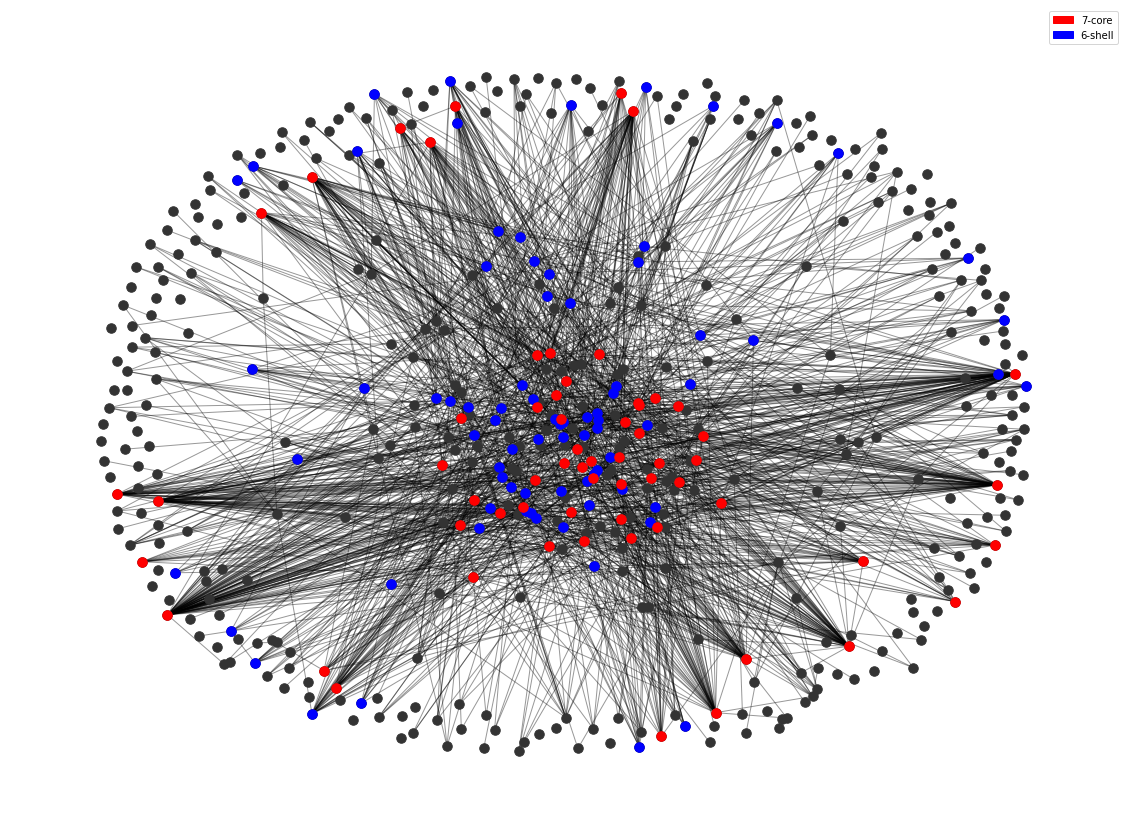

In [ ]:

# Cores mais profundos
shell_6 = nx.k_shell(subgraph_sem_autorreferencia, 6)
core_7 = nx.k_core(subgraph_sem_autorreferencia, 7)

# the degree of network(subgraph_sem_autorreferencia)
fig, ax = plt.subplots(1,1,figsize=(20,15))

# layout position
# pos = nx.spring_layout(subgraph_sem_autorreferencia,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(subgraph_sem_autorreferencia,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(subgraph_sem_autorreferencia,
                 pos=pos,
                 node_color="#333333",node_size = 90)

# draw nodes
nodes = nx.draw_networkx_nodes(shell_6,
                 pos=pos,
                 node_color="blue",node_size = 90)

nodes = nx.draw_networkx_nodes(core_7,
                 pos=pos,
                 node_color="red",node_size = 90)

# static legend
red_patch = mpatches.Patch(color='red', label='7-core')
blue_patch = mpatches.Patch(color='blue', label='6-shell')
plt.legend(handles=[red_patch,blue_patch])

plt.axis("off")
plt.savefig('./figuras/k-core_sociopatterns.png', transparent=True,dpi=600)
plt.show()

Os n√≥s destacados em azul na figura (6 shell) comp√µem a √∫ltima camada extra√≠da antes de sobrar apenas o core (7 core) em vermelho, unindo ambos temos as duas ultimas camadas da decomposi√ß√£o da nossa rede.

Abaixo os usu√°rios que comp√µem as √∫ltimas camadas da rede.

In [ ]:
print("Usu√°rios no 7 Core da rede:")
print(list(core_7.nodes()))
print("\nUsu√°rios no 6 Shell da rede:")
print(list(shell_6.nodes()))

Usu√°rios no 7 Core da rede:
['ruebekah', 'juuh6520', 'imperiobey', 'thnkulmj', 'Isabeliagomes', 'eumaria', 'CentralReaIity', 'mlkfdsa', 'dorismac64', 'Lel20950324', 'doragouvea', 'tracklist', 'PedroScooby', 'LohCorreaa', 'suelivitoria', 'Naiarazevedo', 'Jucy27384738', 'Dantinhas', 'jadre_oficial', 'TvViciada', 'GregoMalandro', 'annaca207', 'beatrixana11', '_seisanjos', 'karolacranessa', 'japacica', 'Petereilissh', 'TalitaS11216598', 'choquei', 'Nnise_Rrose', 'brearps', 'jmileycyrusk', 'Gina35415084', 'DanielF74922660', 'RealitySocial', 'vaidesmaiar', 'canalestrelasyt', 'oficial_deodato', 'voleimomento', 'fezhowrd', 'Alanredd13', 'iasmimdafine', 'JennyNoggy_', 'tia_meigh2', 'juliafagunds20', 'avicmonteiro', 'DHESSIKA16', 'fwntdz', 'wandasinner', 'chicobarney', 'B1aNc4Bass', 'ZAMENZA', 'vitimbrands', 'iampauloandre', 'BonekinhaS22', 'babi', 'bbb', 'Paty13708819', 'tuittaalarii', 'CASIUNABOOKSTAN', 'whomath', 'paiva']

Usu√°rios no 6 Shell da rede:
['larrynoTopo', 'laisfontes10', 'jaquel

### Resultado
Observando os n√≥s das √∫ltimas camadas da rede, tanto na figura quando na c√©lula anterior, podemos perceber que os n√≥s do core realmente s√£o os que possuem maior n√≠vel de conex√£o com os demais, seguidos logo adiante do 6 core em azul. A decomposi√ß√£o nos ajuda a identificar mais facilmente os n√≥s mais relevantes e observar a quantidade de arestas relacionadas a eles.

# Conclus√£o

#### Atrav√©s de todas as an√°lises feitas (M√©tricas de ranqueamento dos n√≥s, PDF, CDF e decomposi√ß√£o da rede) podemos concluir que a rede analisada possui uma baixa conectividade entre os n√≥s, o que no nosso contexto significa que h√° poucas men√ß√µes nos tweets dos usu√°rios aos outros usu√°rios (Mesmo com um tema t√£o recorrente e atual como o Big Brother Brasil 2022).<br><br>Utilizando a ferramenta Gephi constru√≠mos a rede para que fosse poss√≠vel uma melhor visualiza√ß√£o do grafo completo. Nessa constru√ß√£o, o r√≥tulo (Nome dos usu√°rios) e o tamanho dos n√≥s eram proporcionais ao grau deles. Dessa forma, os n√≥s com maior grau obtiveram mais destaque na imagem do que os com menor grau.<br><br>Al√©m disso, voc√™ pode ter acesso ao grafo abaixo de forma iterativa atrav√©s DESSE LINK ou pelo reposit√≥rio do projeto no github.